In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  #Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

2.10.1


In [1]:
# More imports
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, \
  Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
!ls

ml-20m	ml-20m.zip  sample_data


In [ ]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [ ]:
# Now do the same thing for movie ids
# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [ ]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [ ]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

In [ ]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

In [ ]:
# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

In [ ]:
# split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [ ]:
r = model.fit(
  x=[train_user, train_movie],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_movie], test_ratings),
)

Train on 16000210 samples, validate on 4000053 samples
Epoch 1/25
16000210/16000210 - 119s - loss: 0.7774 - val_loss: 0.7246
Epoch 2/25
16000210/16000210 - 122s - loss: 0.7018 - val_loss: 0.7025
Epoch 3/25
16000210/16000210 - 124s - loss: 0.6803 - val_loss: 0.6850
Epoch 4/25
16000210/16000210 - 122s - loss: 0.6644 - val_loss: 0.6757
Epoch 5/25
16000210/16000210 - 128s - loss: 0.6531 - val_loss: 0.6699
Epoch 6/25
16000210/16000210 - 125s - loss: 0.6409 - val_loss: 0.6604
Epoch 7/25
16000210/16000210 - 122s - loss: 0.6242 - val_loss: 0.6502
Epoch 8/25
16000210/16000210 - 116s - loss: 0.6111 - val_loss: 0.6473
Epoch 9/25
16000210/16000210 - 116s - loss: 0.6020 - val_loss: 0.6443
Epoch 10/25
16000210/16000210 - 119s - loss: 0.5944 - val_loss: 0.6398
Epoch 11/25
16000210/16000210 - 135s - loss: 0.5871 - val_loss: 0.6370
Epoch 12/25
16000210/16000210 - 125s - loss: 0.5804 - val_loss: 0.6338
Epoch 13/25
16000210/16000210 - 126s - loss: 0.5737 - val_loss: 0.6414
Epoch 14/25
16000210/16000210 -

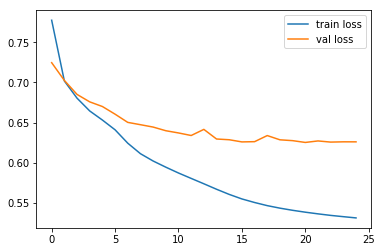

In [ ]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [ ]:
# is this on par with other approaches?
# https://datascience.stackexchange.com/questions/29740/benchmark-result-for-movielens-dataset
np.sqrt(0.6259)

0.7911384202527394